# Cost function and gradient descent algorithm

In this notebook I will try and implement a cost function for linear regression with one variable

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#we are again using the same values as the ones shown in the previous notebook
#x_training is the size of the house expressed in square meters; here acts as the input variable
#y_training is the price of the house expressed in euros 
#and is written as the product between the square meters size of the house and the average price for that neighborood of the city;
#here it acts as the output variable
x_training = np.array([45, 75, 100, 120, 150, 200])
y_training = np.array([45*2100, 75*2100, 100*2563, 120*1615, 150*2100, 200*2100])

The equation for the a cost function of one variable looks like this $J(w,b)=\frac{1}{2m}\sum_i(f_{w,b}(x^{i})-y^{i})^{2}$ where:

- $f_{w,b}(x^{i})$ is the i-th prediction with parameters w and b 
- $(f_{w,b}(x^{i})-y^{i})^{2}$ is the squared difference between target value and prediction
- these differences are summed over all m samples and divided by $2m$ to produce the cost function $J(w,b)$

Now we try to develop a function which computes the cost looping over each sample.

In [4]:
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    cost_sum = 0 
    for i in range(m): 
        f_wb = w * x[i] + b   
        cost = (f_wb - y[i]) ** 2  
        cost_sum = cost_sum + cost  
    total_cost = (1 / (2 * m)) * cost_sum  

    return total_cost

The goal here is to find a model $f(w,b)=wx+b$ with parameter w and b such that will predict house values correctly given an input x (here the size in square meters); in this scenario the cost becomes a measure of how accurate the model is on the training data.

In [12]:
#regression diagnostic plots: scatter, contour of cost J(w,b), 3D surface of J(w,b)
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

def compute_cost_grid(x, y, w_vals, b_vals):
    """Compute cost J(w,b) on a grid of w_vals and b_vals.
       Returns W, B, J where W,B are meshgrid arrays and J the same shape.
    """
    m = len(x)
    W, B = np.meshgrid(w_vals, b_vals)   # shape (len(b_vals), len(w_vals))
    J = np.zeros_like(W, dtype=float)
    # naive but clear loop: fine for moderate grid sizes (e.g. 50x50)
    for i in range(B.shape[0]):
        for j in range(W.shape[1]):
            w = W[i, j]
            b = B[i, j]
            preds = w * x + b
            J[i, j] = np.sum((preds - y) ** 2) / (2 * m)
    return W, B, J

def plot_regression_diagnostics(x, y,
                                w_range=None, b_range=None,
                                nw=80, nb=80,
                                figsize=(15,5),
                                savepath=None):
    """
    Produce three side-by-side plots:
     - scatter with fitted line
     - contour plot of J(w,b) with ellipses and the fitted (w,b) point
     - 3D surface plot of J(w,b)

    x, y : 1D arrays (sizes, prices)
    w_range, b_range : optionally (wmin,wmax) and (bmin,bmax). If None, computed from data.
    nw, nb : grid resolution for w and b
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = len(x)
    if m == 0:
        raise ValueError("Empty dataset")

    # Fit a simple linear regression (least squares) for plotting the "best" line
    # np.polyfit returns [w, b] for degree=1 when using np.polyfit(x,y,1)
    w_fit, b_fit = np.polyfit(x, y, 1)

    # determine ranges for w and b if not provided
    if w_range is None:
        # create a reasonable band around fitted w
        w_range = (w_fit - 1.5 * abs(w_fit + 1e-6), w_fit + 1.5 * abs(w_fit + 1e-6))
    if b_range is None:
        b_range = (b_fit - 0.8 * max(abs(b_fit), 1e-6), b_fit + 0.8 * max(abs(b_fit), 1e-6))

    w_vals = np.linspace(w_range[0], w_range[1], nw)
    b_vals = np.linspace(b_range[0], b_range[1], nb)

    W, B, J = compute_cost_grid(x, y, w_vals, b_vals)

    # Prepare figure with 3 subplots
    fig = plt.figure(figsize=figsize)
    # Subplot 1: scatter + fitted line
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(x, y, label="Data", zorder=2)
    xs = np.linspace(x.min(), x.max(), 200)
    ax1.plot(xs, w_fit * xs + b_fit, color='orange', label=f"Fit: y={w_fit:.2f}x+{b_fit:.1f}", zorder=3)
    ax1.set_xlabel("Size (m²)")
    ax1.set_ylabel("Price (€)")
    ax1.set_title("Size vs Price (scatter + fit)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot 2: contour (ellipses) of J(w,b)
    ax2 = fig.add_subplot(1, 3, 2)
    # choose contour levels: nicely spaced from near-min to some quantile
    Jmin = J.min()
    Jmax = np.percentile(J, 95)  # avoid extreme outliers in contour
    levels = np.logspace(np.log10(Jmin+1e-3), np.log10(Jmax), 20)
    CS = ax2.contour(W, B, J, levels=levels, cmap='viridis')
    ax2.clabel(CS, inline=True, fontsize=8, fmt="%.0f")
    ax2.scatter([w_fit], [b_fit], color='red', s=50, label='LS fit (w,b)')
    ax2.set_xlabel("w (slope)")
    ax2.set_ylabel("b (intercept)")
    ax2.set_title("Contour of Cost J(w,b)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Subplot 3: 3D surface of J(w,b)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    # Surface: use a smaller grid (or same) - plot_surface expects X,Y,Z with same shape
    surf = ax3.plot_surface(W, B, J, cmap='viridis', edgecolor='none', alpha=0.9, rcount=50, ccount=50)
    ax3.set_xlabel("w (slope)")
    ax3.set_ylabel("b (intercept)")
    ax3.set_zlabel("J(w,b)")
    ax3.set_title("Surface of Cost J(w,b)")
    fig.colorbar(surf, ax=ax3, shrink=0.5, aspect=10, pad=0.1)

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

    # return computed important items in case you want to use them programmatically
    return {'w_fit': w_fit, 'b_fit': b_fit, 'W': W, 'B': B, 'J': J}


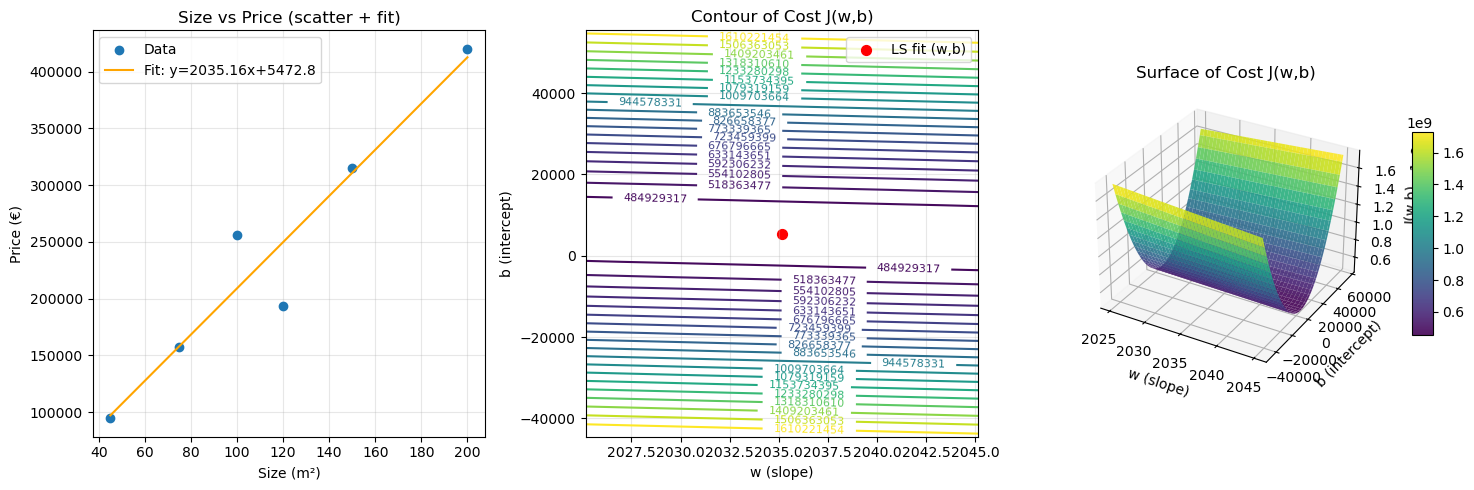

In [14]:
#example synthetic dataset
results = plot_regression_diagnostics(x_training, y_training,
                                      w_range=(results['w_fit']-10, results['w_fit']+10),
                                      b_range=(results['b_fit']-50000, results['b_fit']+50000))


In [8]:
print("J min =", results['J'].min(), "J max =", results['J'].max())
print(results['J'].max()/results['J'].min())

J min = 455512993.9760956 J max = 75428263303.35567
165.58970721110535
